<h1>Проект <br>
"Определение возраста человека на фотографии"</h1>

Яндекс Практикум 
Спринт 19 "Компьютерное зрение"

Бриф проекта: <br>
Дана выборка фотографий людей с разметкой возраста человека на фото, необходимо обучить нейросеть для определения возраста человека на фотографии, мера MAE итоговой модели должна быть не выше 8.
Для решения задачи необходимо определить нейросеть с линейной регрессией (без активации, функция потерь MSE) с 1 выходящим нейроном, равным приблизительному возрасту человека на фото.

Используемые библиотеки: <br>
Keras, Adam, ResNet50

<h2> Часть 1. Предобработка данных</h2> 

<h3>1.1. Импорт библиотек</h3> 

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


print('Библиотеки загружены')

Библиотеки загружены


<h3>1.2. Загрузка данных</h3> 

In [ ]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('https://code.s3.yandex.net//datasets/faces/labels.csv')  

print('Файл данных загружен')

Файл данных загружен


In [ ]:
datagen = ImageDataGenerator(rescale = 1/255)

train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory='/datasets/faces/final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 seed=1111)

print('Данные извлечены')

Found 7591 validated image filenames.
Данные извлечены


<h3>1.3. Получение общей информации о датасете</h3> 

In [ ]:
display(labels.head(5))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
display(labels.info())
display(labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<h3>1.4. График распределения данных</h3> 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Real age')

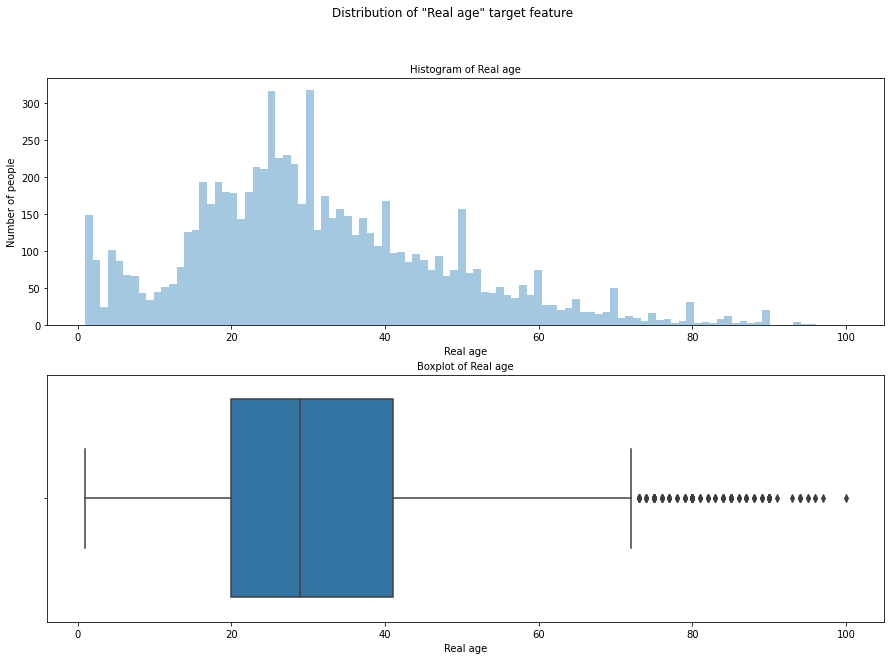

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle(f'Distribution of "Real age" target feature')

ax = plt.subplot(2, 1, 1)
sns.distplot(labels['real_age'], bins=100, kde=False)
plt.xlabel('Real age')
plt.ylabel('Number of people')
plt.title('Histogram of Real age', fontsize=10)

ax = plt.subplot(2, 1, 2)
sns.boxplot(labels['real_age'])
plt.xlabel('Real age')
plt.title('Boxplot of Real age', fontsize=10)


<h3>1.5. Пример данных</h3> 

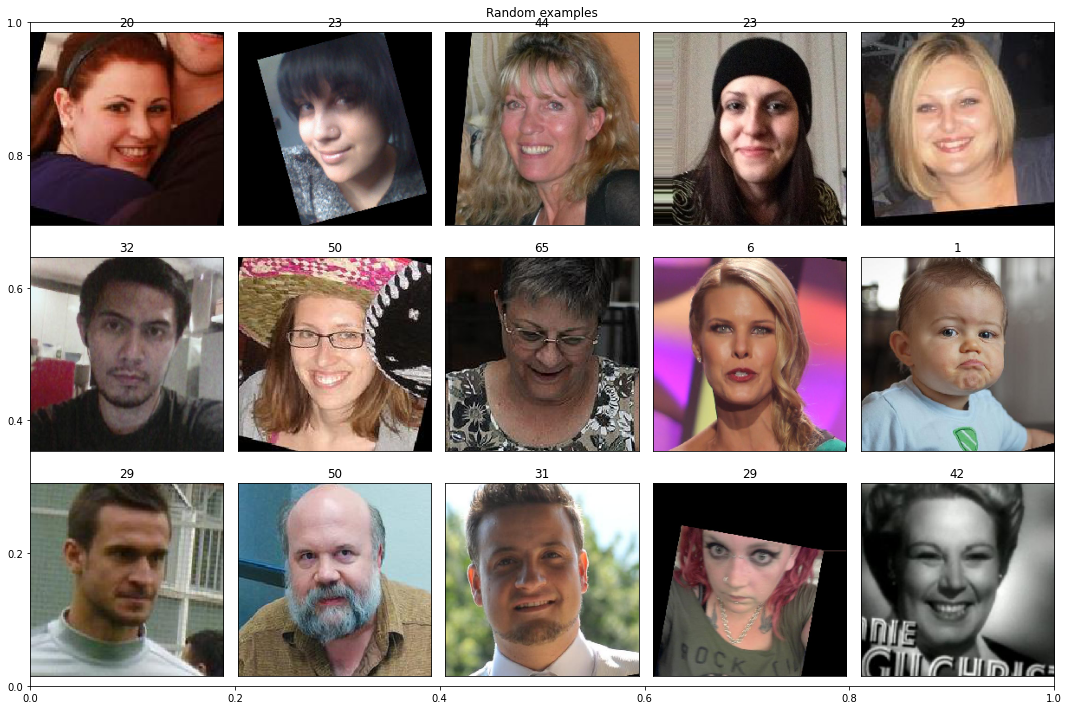

In [ ]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(15, 10))
plt.title('Random examples')

for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

Вывод: <br>
Датасет содержит 7591 фотографий с указанием возраста человека на фото.<br>
Пропусков данных нет, выбросов или нетипичных значений нет.<br>
Большинство людей на фотографиях в возрасте от 1 года до 41 года, <br>
медианный возраст составляет 29 лет, при этом максимальный возраст 100 лет. <br>
Распределение возраста людей не симметрично: имеет локальный максимум в возрасте 1 год и тяжелый правый хвост.<br>
Набор фотографий содержит цветные и черно-белые фотографии, фотографии анфас и в профиль, <br>
фотографии с частично закрытым лицом или глазами, фотографии, на которых присутствуют так же другие люди. <br>
фотографии выровнены по горизонтали (из-за чего на данных фотографиях есть черные рамки), <br>
качество фотографий так же различается.

<h2> Часть 2. Обучение модели </h2> 

In [ ]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, 
                                 horizontal_flip = True, 
                                 validation_split=0.25
                                 )
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=1111
                                                 )

    return train_datagen_flow

In [ ]:
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.25
                                 )
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='validation',
                                                 seed=1111
                                                 )

    return test_datagen_flow

In [ ]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model


In [ ]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=10,
                steps_per_epoch=None, 
                validation_steps=None
                ):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 66s - loss: 233.6289 - mae: 11.0166 - val_loss: 1015.1604 - val_mae: 26.9836
Epoch 2/10
178/178 - 38s - loss: 76.6742 - mae: 6.5868 - val_loss: 647.1963 - val_mae: 20.1009
Epoch 3/10
178/178 - 39s - loss: 52.2685 - mae: 5.4851 - val_loss: 346.0398 - val_mae: 13.9804
Epoch 4/10
178/178 - 39s - loss: 36.9521 - mae: 4.5971 - val_loss: 98.2067 - val_mae: 7.5103
Epoch 5/10
178/178 - 38s - loss: 27.8193 - mae: 4.0854 - val_loss: 86.8955 - val_mae: 6.9911
Epoch 6/10
178/178 - 38s - loss: 22.0495 - mae: 3.5620 - val_loss: 76.8368 - val_mae: 6.7479
Epoch 7/10
178/178 - 38s - loss: 16.9721 - mae: 3.1457 - val_loss: 66.5878 - val_mae: 6.1477
Epoch 8/10
178/178 - 38s - loss: 13.9621 - mae: 2.8292 - val_loss: 69.9141 - val_mae: 6.1218
Epoch 9/10
178/178 - 38s - loss: 12.6974 - mae: 2.7034 - val_loss: 66.9310 - val_mae: 6.2186
Epoch 10/10
178/178 - 38s - loss: 10.2421 - mae: 2.4412 - val_loss: 64.4920 - val_mae: 5.9044

60/60 - 9s - loss: 64.4920 - mae: 5.9044
Test MAE: 5.9044

Вывод: <br>
Сеть с архитектурой типа ResNet50 определяет возраст человека на фотографии <br>
с мерой MAE на тестовой выборке равной 5.9 <br>
(что удовлетворяет условию задачи получить оценку MAE<8>)

<h2> Часть 3. Общий вывод </h2> 

Согласно поставленной задаче необходимо было по выборке фотографий людей с указанием возраста <br>
построить нейросеть для определения возраста покупателя сетевого супермаркета. <br>
Для решения задачи была построена сеть с архитектурой ResNet50. <br>
Итоговая модель определяет возраст человека на фото с погрешностью <br>
в приблизительно 6 лет (MAE=5.9 на тестовой выборке). <br>
Данная погрешность в случае использования модели для целевого маркетинга не является значительной, <br>
поскольку в этом случае важна возрастная группа покупателя, а не конкретный возраст. <br>
В случае же использования модели в магазине для определения допустимости продажи алкоголя покупателю <br>
данная погрешность может быть критически важной. Поэтому при определении нейросетью возраста покупателя <br>
в диапазоне от 12 до 24 лет (если продажа алкоголя запрещена до 18 лет) <br>
необходима так же проверка документов покупателя работником магазина.